In [1]:
from typing import List
from copy import deepcopy
import pandas as pd

import ase
from ase import Atoms
from ase.calculators.lj import LennardJones
from ase.io import Trajectory
from ase.calculators.calculator import Calculator, all_changes

import numpy as np
import matplotlib.pyplot as plt

from cascade.utils import canonicalize

%load_ext autoreload
%autoreload 2

In [2]:
atoms = Atoms('N2')

In [3]:
atoms.positions

array([[0., 0., 0.],
       [0., 0., 0.]])

In [4]:
def sample_diatomic_distances(
    atoms_str: str = 'N2', 
    dist_range: tuple = (1.1, 3), 
    n: int = 100) -> List[ase.Atoms]:     
    """Create a trajectory of a diatomic system with linearly sampled distances
    atoms_str: ase specification of diatomic
    dist_range: (angsroms) range of distances to sample
    n: number of samples
    """
    atoms = Atoms(atoms_str)
    trajectory = []
    x_vals = np.linspace(*dist_range, n)
    for x in x_vals: 
        atoms = atoms.copy()
        atoms.set_positions([[0,0,0], [x, 0, 0]])
        trajectory.append(atoms)
    return trajectory

In [5]:
def apply_calculator(
    calc: ase.calculators.calculator.Calculator, 
    traj: List[ase.Atoms]) -> List[Atoms]:
    """Run a calculator on every atoms object in a list"""

    traj = deepcopy(traj)
    for i, atoms in enumerate(traj): 
        atoms.calc = calc
        atoms.get_forces()
        traj[i] = canonicalize(atoms)
    return traj

In [6]:
lj1, lj2  = LennardJones(sigma=1, eps=1), LennardJones(sigma=1, epsilon=1.1)

In [7]:
traj_base = sample_diatomic_distances()
traj_lj1  = apply_calculator(lj1, traj_base)
traj_lj2  = apply_calculator(lj2, traj_base)

In [8]:
traj_lj1[:3]

[Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...)),
 Atoms(symbols='N2', pbc=False, calculator=SinglePointCalculator(...))]

In [9]:
traj_lj1[0].calc.results

{'energies': array([-0.4889465, -0.4889465]),
 'forces': array([[-1.58809539,  0.        ,  0.        ],
        [ 1.58809539,  0.        ,  0.        ]]),
 'energy': -0.9778930076294439,
 'free_energy': -0.9778930076294439}

In [10]:
def get_diatomic_quantities(traj):
    positions, forces = [], []
    for atoms in traj: 
        positions.append(atoms.positions[1,0])
        forces.append(atoms.calc.results['forces'][0,0])
        
    return tuple(map(np.asarray, [positions, forces]))

In [11]:
x_lj1, f_lj1 = get_diatomic_quantities(traj_lj1)
x_lj2, f_lj2 = get_diatomic_quantities(traj_lj2)

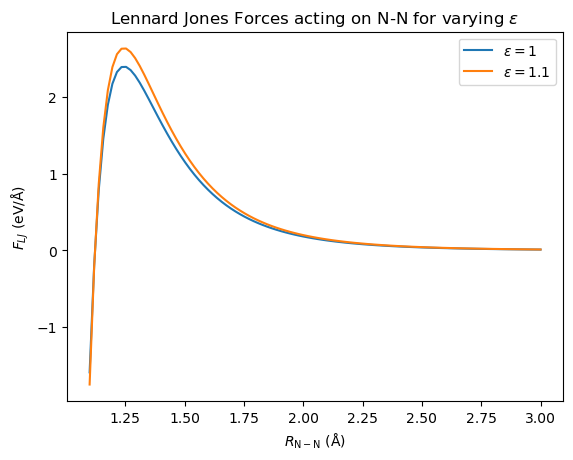

In [12]:
plt.plot(x_lj1, f_lj1, label='$\epsilon=1$')
plt.plot(x_lj1, f_lj2, label='$\epsilon=1.1$')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')
plt.ylabel('$F_{LJ}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.title('Lennard Jones Forces acting on N-N for varying $\epsilon$');

In [13]:
abs_err = np.abs(f_lj1 - f_lj2)

Text(0.5, 0, '$R_\\mathrm{{N-N}}$ ($\\mathrm{\\AA}$)')

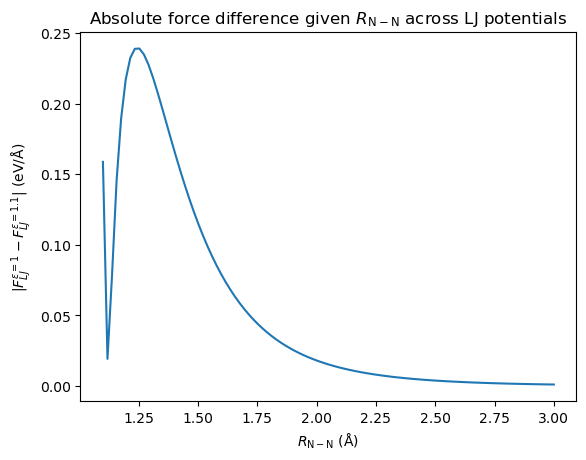

In [14]:
plt.plot(x_lj1, abs_err)
plt.title('Absolute force difference given $R_\mathrm{{N-N}}$ across LJ potentials')
plt.ylabel('$|F^{\epsilon=1}_{LJ} - F^{\epsilon=1.1}_{LJ}|$ (eV/$\mathrm{\AA}$)')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')

## Try out the ensemble class and auditor

In [15]:
from cascade.calculator import EnsembleCalculator

In [16]:
ens = EnsembleCalculator([lj1, lj2])

In [17]:
traj_ens = apply_calculator(ens, traj_base)

In [18]:
x_ens, f_mean = get_diatomic_quantities(traj_ens)

We see that the mean trajectory is the mean of the two trajectories

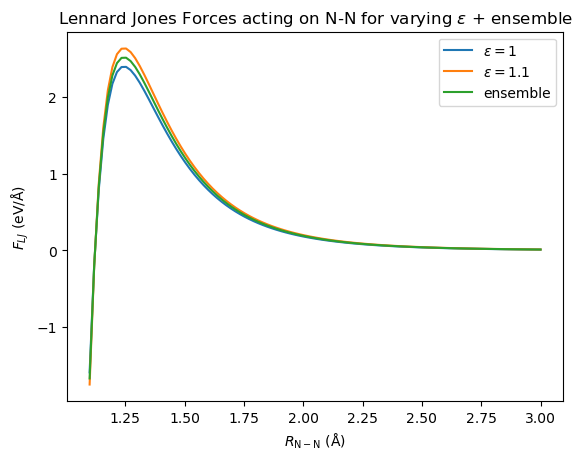

In [19]:
plt.plot(x_lj1, f_lj1, label='$\epsilon=1$')
plt.plot(x_lj2, f_lj2, label='$\epsilon=1.1$')
plt.plot(x_ens, f_mean, label='ensemble')
plt.xlabel('$R_\mathrm{{N-N}}$ ($\mathrm{\AA}$)')
plt.ylabel('$F_{LJ}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.title('Lennard Jones Forces acting on N-N for varying $\epsilon$ + ensemble');

In [20]:
uq_ens = [a.info['forces_ens'].std(0).max() for a in traj_ens]

And that the UQ is perfectly correlated with the absolute error in this case

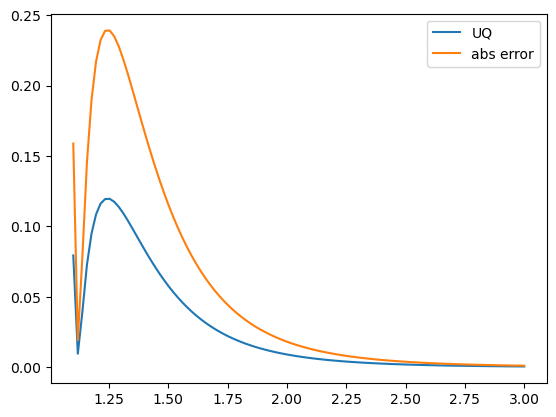

In [21]:
plt.plot(x_ens, uq_ens, label='UQ')
plt.plot(x_lj1, abs_err, label='abs error')
plt.legend()
plt.xlabel('R ($\mathrm{\AA}')

In [22]:
from cascade.auditor import ForceThresholdAuditor

We can see the auditor picks out the right frames. I do wonder if it is too conservative though: it says there is a 50% chance but really the error is far below the threshold. Perhaps calibration will help us here? 

In [23]:
auditor = ForceThresholdAuditor(threshold=1)
p_any, audits = auditor.audit(traj_ens, n_audits=100, sort_audits=True)
p_any, audits

(0.57,
 array([ 8,  7,  9,  6, 10, 11,  5, 12, 13,  4, 14, 15, 16,  0, 17,  3, 18,
        19, 20, 21, 22, 23, 24, 25, 26,  2, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,  1, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

In [24]:
abs_err_argsort = np.argsort(abs_err)[::-1]

In [25]:
(abs_err_argsort == audits).all()

True